In [1]:
from datasets import load_dataset
from fastai.torch_core import show_images
import torch
from torchvision import transforms

In [2]:
fashion_mnist = load_dataset("fashion_mnist")

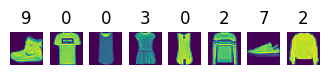

In [3]:
clothes = fashion_mnist["train"]["image"][:8]
classes = fashion_mnist["train"]["label"][:8]
show_images(clothes, titles=classes, figsize=(4, 2.5))

In [4]:
preprocess = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
    transforms.ToTensor(),
    transforms.Pad(2),  # Convert to tensor (0, 1)
    # Add 2 pixels on all sides
    transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
])

In [5]:
batch_size = 256

def transform(examples):
    images = [preprocess(image.convert("L")) for image in examples["image"]]
    return {"images": images, "labels": examples["label"]}

train_dataset = fashion_mnist["train"].with_transform(transform)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

In [6]:
from diffusers import UNet2DModel

model = UNet2DModel(
    in_channels=1,
    # 1 channel for grayscale images
    out_channels=1,
    sample_size=32,
    # output channels must also be 1
    block_out_channels=(32, 64, 128, 256),
    norm_num_groups=8,
    num_class_embeds=10,  # Enable class conditioning
)

In [7]:
x = torch.randn((1, 1, 32, 32))
with torch.no_grad():
    out = model(x, timestep=7, class_labels=torch.tensor([2])).sample
out.shape

torch.Size([1, 1, 32, 32])

In [8]:

from diffusers import DDPMScheduler

scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02)
timesteps = torch.linspace(0, 999, 8).long()
batch = next(iter(train_dataloader))

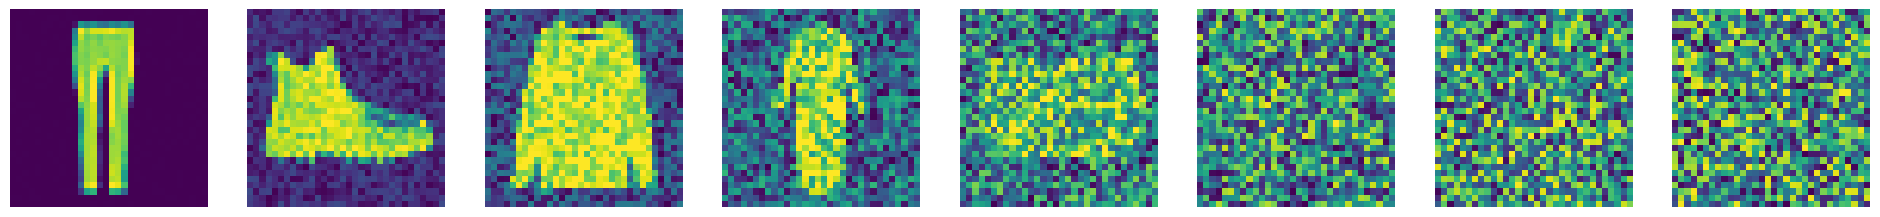

In [9]:
import os

os.environ[
    "PYTORCH_HIP_ALLOC_CONF"] = "garbage_collection_threshold:0.9,max_split_size_mb:128"
x = batch['images'][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x*0.5 + 0.5).clip(0, 1))

In [17]:
from tqdm import tqdm
import torch
import os

os.environ[
    "PYTORCH_HIP_ALLOC_CONF"] = "garbage_collection_threshold:0.9,max_split_size_mb:128"

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def generate_from_class(class_to_generate, n_samples=8):
    model.to("cuda")
    model.train()
    sample = torch.randn(n_samples, 1, 32, 32).to(device)
    class_labels = [class_to_generate] * n_samples
    class_labels = torch.tensor(class_labels).to(device)
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        #Get model pred
        with torch.no_grad():
            noise_pred = model(sample, t, class_labels=class_labels).sample
            # Update sample with step
        sample = scheduler.step(noise_pred, t, sample).prev_sample
    return sample.clip(-1, 1) * 0.5 + 0.5

0it [00:00, ?it/s]/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/diffusers/models/attention_processor.py:1279: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:264.)
  hidden_states = F.scaled_dot_product_attention(
/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/diffusers/models/attention_processor.py:1279: UserWarning: 1Torch was not compiled with memory efficient attention. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:320.)
  hidden_states = F.scaled_dot_product_attention(
1000it [00:43, 23.10it/s]


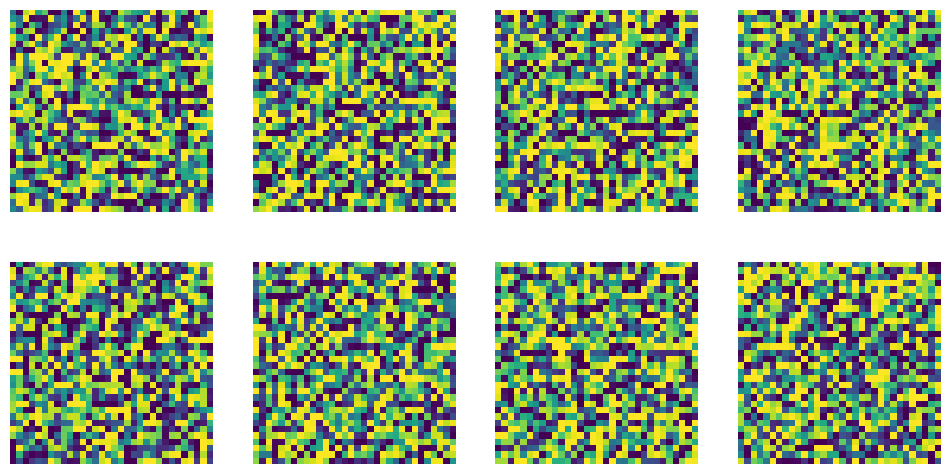

In [18]:
import os

os.environ[
    "PYTORCH_HIP_ALLOC_CONF"] = "garbage_collection_threshold:0.9,max_split_size_mb:128"
# Generate t-shirts (class 0)
images = generate_from_class(0)
show_images(images, nrows=2)

1000it [00:41, 24.31it/s]


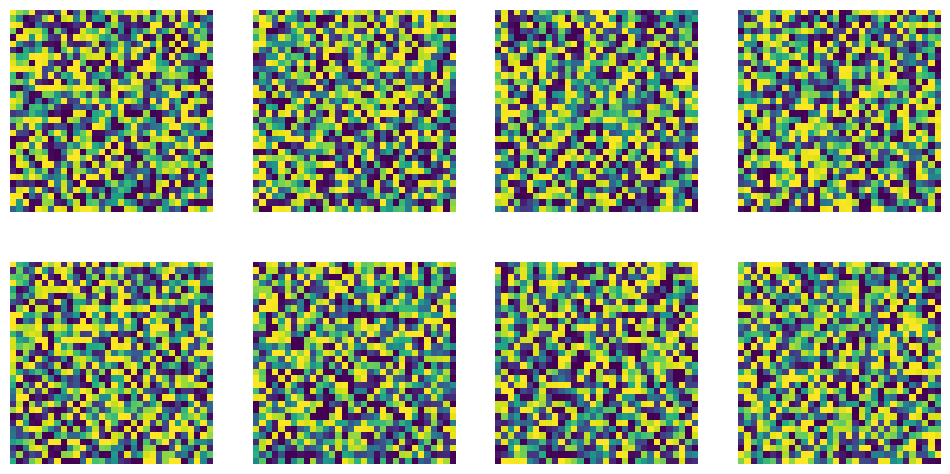

In [19]:
import os

os.environ[
    "PYTORCH_HIP_ALLOC_CONF"] = "garbage_collection_threshold:0.9,max_split_size_mb:128"
images = generate_from_class(7)
show_images(images, nrows=2)

1000it [00:40, 24.61it/s]


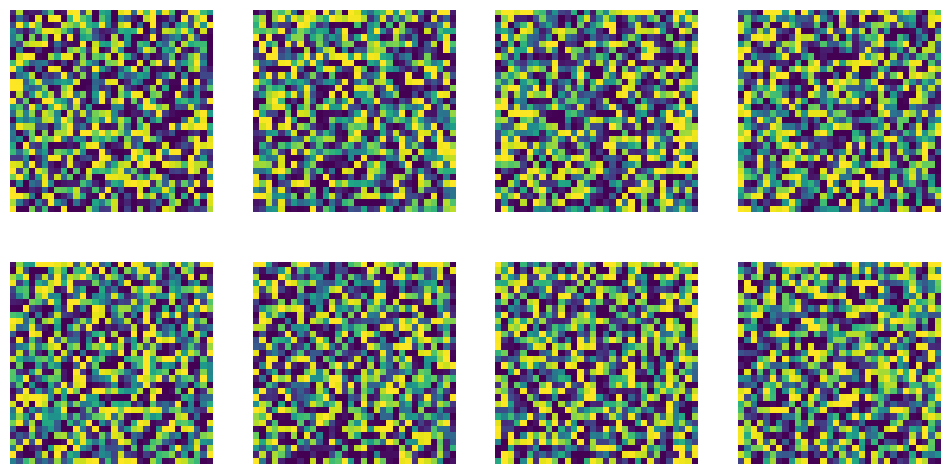

In [20]:
import os

os.environ[
    "PYTORCH_HIP_ALLOC_CONF"] = "garbage_collection_threshold:0.9,max_split_size_mb:128"
images = generate_from_class(9)
show_images(images, nrows=2)